In [4]:
import os
import tarfile
import matplotlib.pyplot as plt
import pandas as pd
import torch
from pathlib import Path
from NeuralNMF import train
from sklearn.feature_extraction.text import TfidfVectorizer
from NeuralNMF import Neural_NMF
import pickle
import scipy.io
import random
import numpy as np


np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)


In [5]:
def NNMF(dataset,layers,day,mouse,timeframes):
    trainS = dataset["S"][0][day]
    opto = dataset["opt"][0][day]

    layers.insert(0,trainS.shape[0]*timeframes)

    trainData = []
    for i in range(trainS.shape[1]-timeframes+1):
        segment = trainS[:,i:i+timeframes]
        flatt = segment.flatten(order='F')
        trainData.append(flatt)
    trainMatrix = np.array(trainData).T

    train__ = torch.tensor(trainMatrix)
    net = Neural_NMF(layers)
    history = train(net, train__, epoch=10, lr=500, supervised=False)

    A = history[0][len(layers)-2]
    S = history[1][len(layers)-2]
    A1 = history[0][0].detach().numpy()
    Afinal = A.detach().numpy()
    S1 = S.detach().numpy()

    # count_ones = np.count_nonzero(opto == 1)
    indices = np.where(opto == 1)[1]
    slices = []
    for idx in indices:
        if idx + 20 <= S1.shape[1]:
            slices.append(S1[:, idx:idx+20])
        else:
            slices.append(S1[:, idx:])
    C = np.hstack(slices) if slices else np.array([])

    # if(len(layers)>2):
    #     a1 = history[0][0]
    #     a2 = history[0][1]
    #     a1a2 = torch.matmul(a1,a2)
    #     a12_ = a1a2[:,0]
    #     o,p,n = a12_[:trainS.shape[0]],a12_[trainS.shape[0]:trainS.shape[0]*2],a12_[trainS.shape[0]*2:trainS.shape[0]*3]
    #     o,p,n = o.reshape(-1,1),p.reshape(-1,1),n.reshape(-1,1)
    #     result_matrix = torch.cat((o, p, n), dim=1)

    #     plt.imshow(result_matrix.detach().numpy(), cmap='hot', interpolation='nearest')
    #     plt.colorbar()  # Show color scale
    #     plt.title('Heat Map of PyTorch Tensor A1*A2')
    #     plt.show()

    plt.imshow(A1[:,:], cmap='hot', interpolation='nearest')
    plt.colorbar()  # Show color scale
    plt.title(f'Heat Map of A1 Mouse {mouse} for Day {day+1} with timeframes = {timeframes}')
    plt.show()

    plt.imshow(Afinal[:,:], cmap='hot', interpolation='nearest')
    plt.colorbar()  # Show color scale
    plt.title(f'Heat Map of A_Final Mouse {mouse} for Day {day+1} with timeframes = {timeframes}')
    plt.show()

    plt.imshow(C[:,:100], cmap='hot', interpolation='nearest')
    plt.colorbar()  # Show color scale
    plt.title(f'Heat Map of S matrix for Mouse {mouse} for Day {day+1} with timeframes = {timeframes}')
    plt.show()

    #activations of neurons
    
    number = trainS.shape[0]
    y = np.arange(1, number+1)
    # Create the horizontal stacked bar graph
    fig, ax = plt.subplots(figsize=(10, number*0.1))  # Adjust the size to fit the labels better
    bar_height = 0.35
    index = np.arange(number)
    # Plot the bars
    bar1 = ax.barh(index, A1[:number, 0], bar_height, label='Column 1')
    bar2 = ax.barh(index, A1[:number, 1], bar_height, left=A1[:number, 0], label='Column 2')
    # Adding labels and title
    ax.set_ylabel('Neurons')
    ax.set_xlabel('Activation Value')
    ax.set_title(f'Activation of Each Neuron in A1 matrix for Mouse {mouse} for Day {day+1} with timeframes = {timeframes}')
    ax.set_yticklabels([])
    ax.legend()
    plt.show()

    number = layers[1]
    y = np.arange(1, number+1)
    # Create the horizontal stacked bar graph
    fig, ax = plt.subplots(figsize=(5, number*0.1))  # Adjust the size to fit the labels better
    bar_height = 0.35
    index = np.arange(number)
    # Plot the bars
    bar1 = ax.barh(index, Afinal[:number, 0], bar_height, label='Column 1')
    bar2 = ax.barh(index, Afinal[:number, 1], bar_height, left=Afinal[:number, 0], label='Column 2')
    # Adding labels and title
    ax.set_ylabel('Neurons')
    ax.set_xlabel('Activation Value')
    ax.set_title(f'Activation of Each Neuron in A1 matrix for Mouse {mouse} for Day {day+1} with timeframes = {timeframes}')
    ax.set_yticklabels([])
    ax.legend()
    plt.show()
    return history,Afinal,S1,C,ax,fig

100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


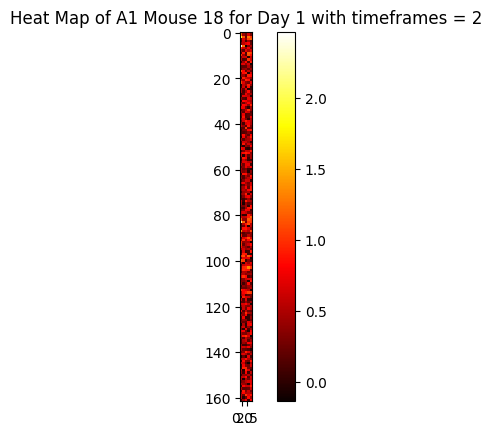

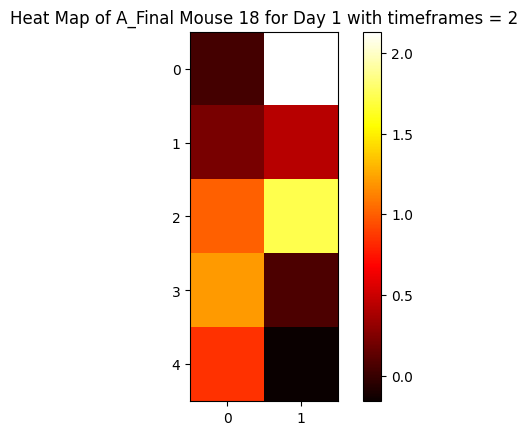

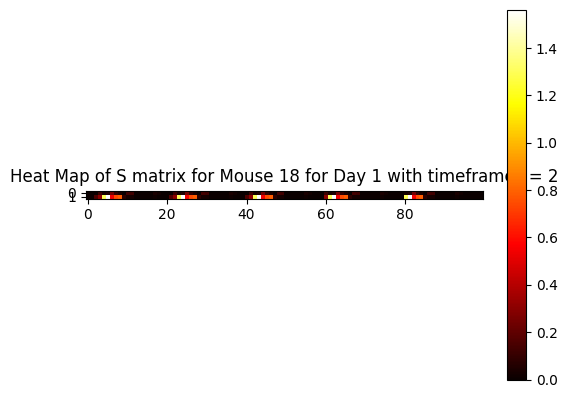

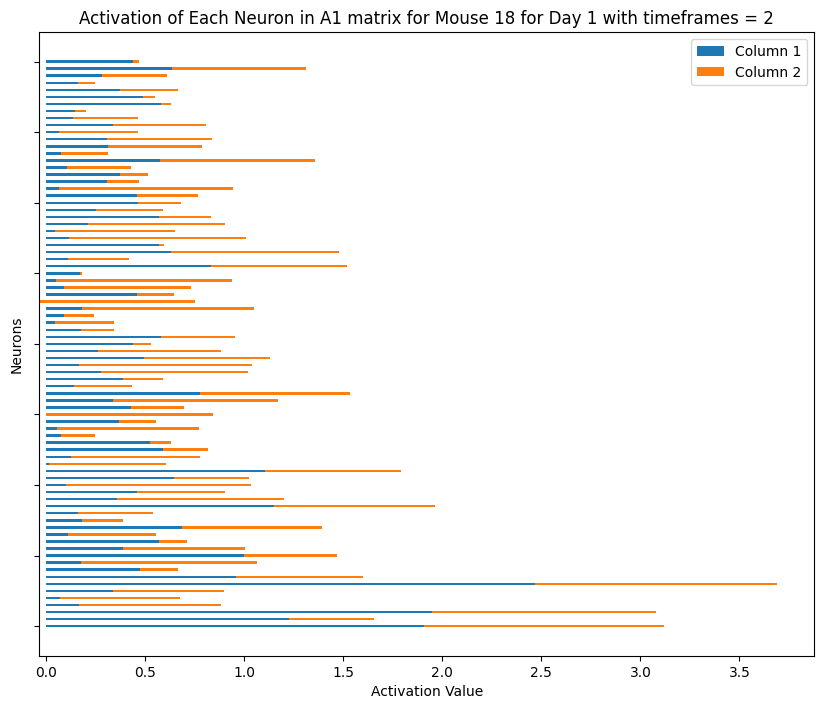

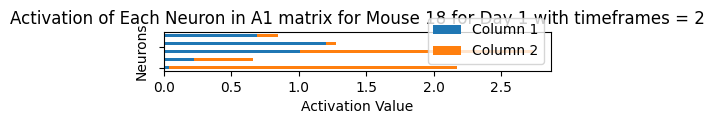

100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


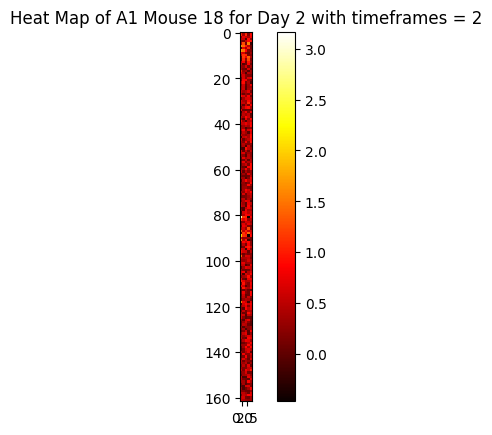

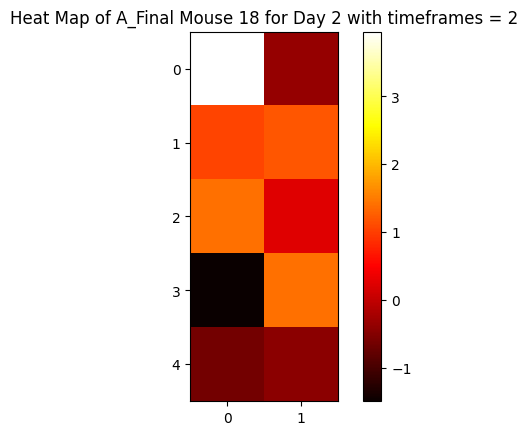

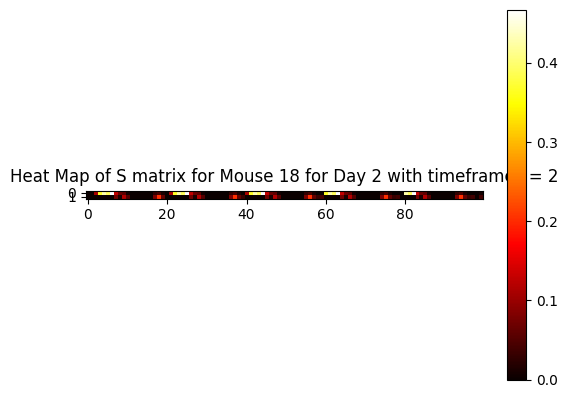

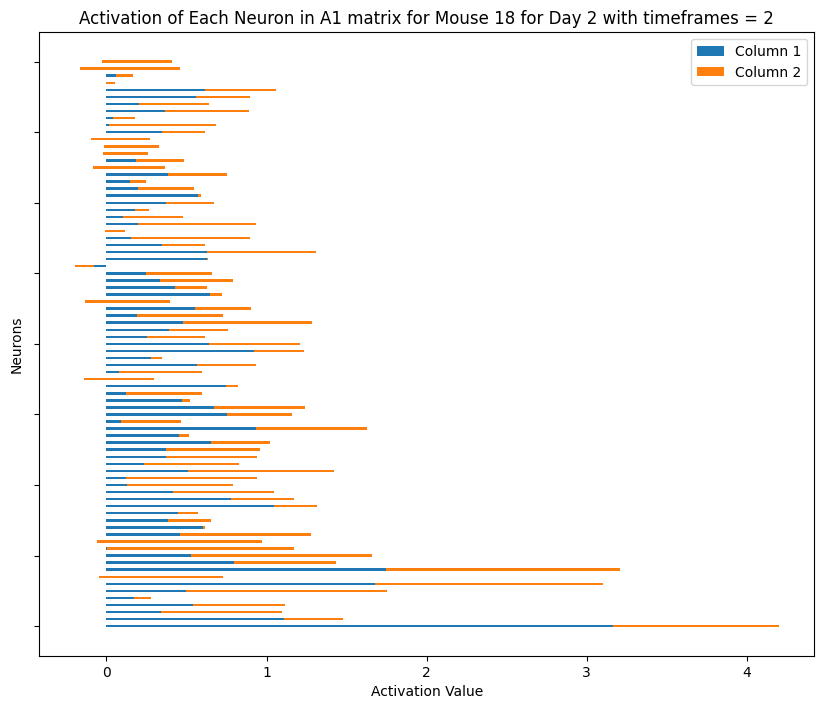

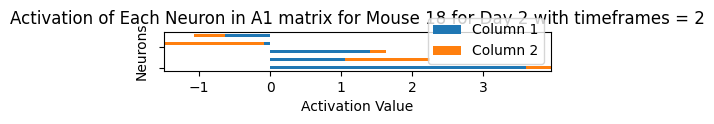

100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


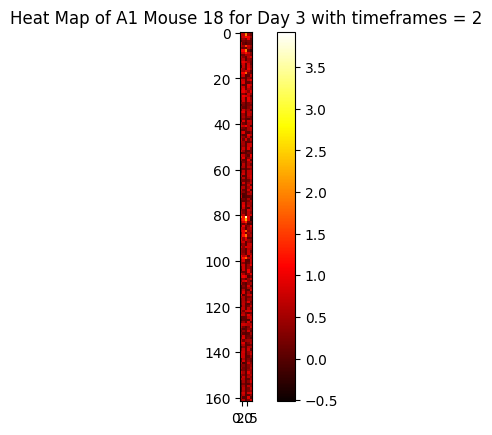

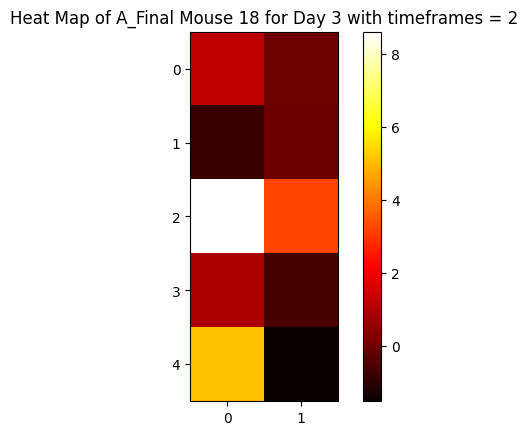

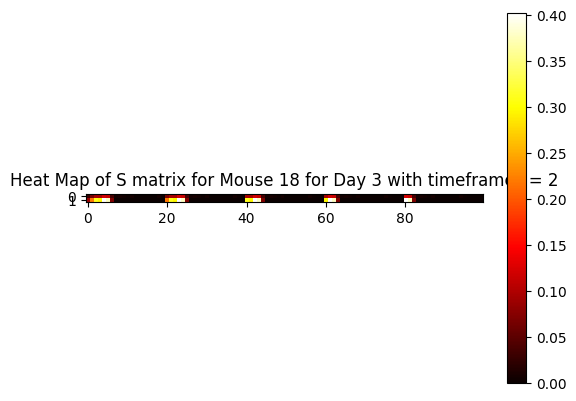

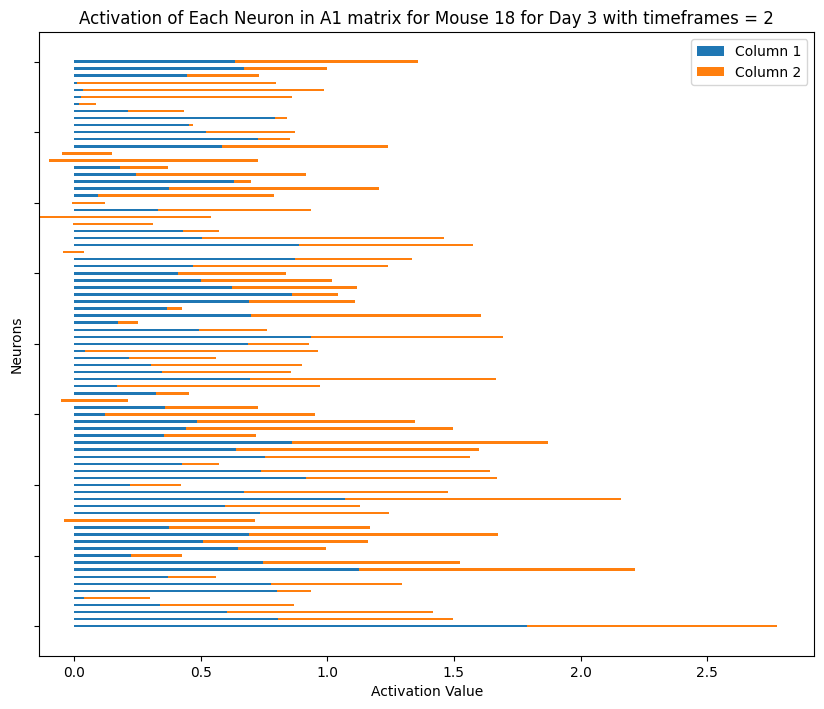

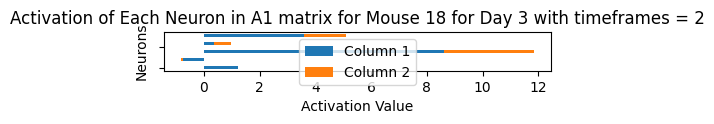

100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


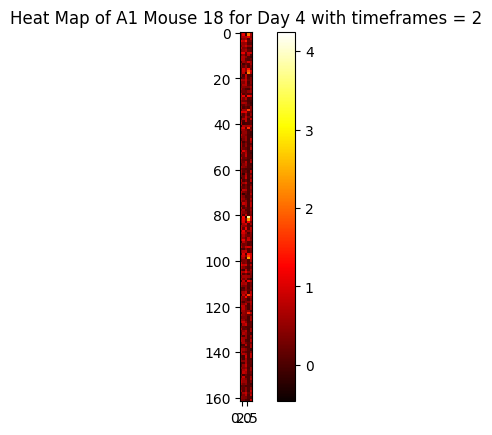

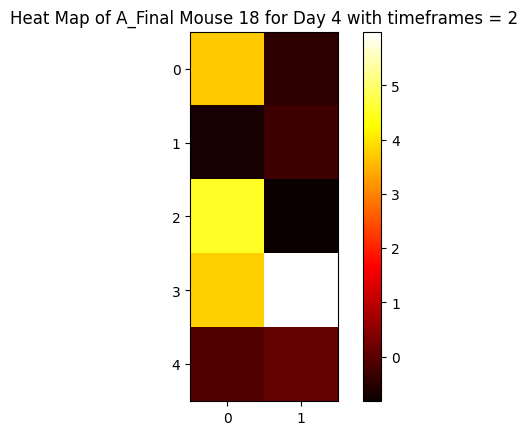

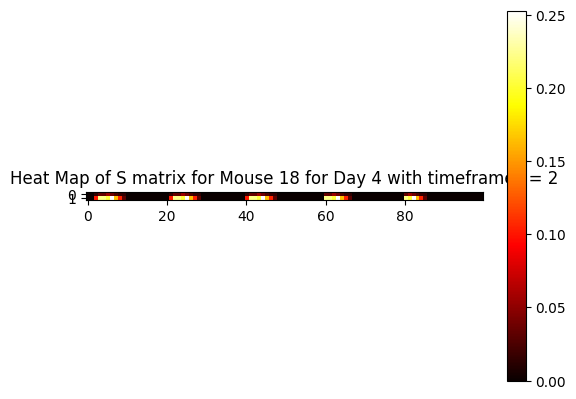

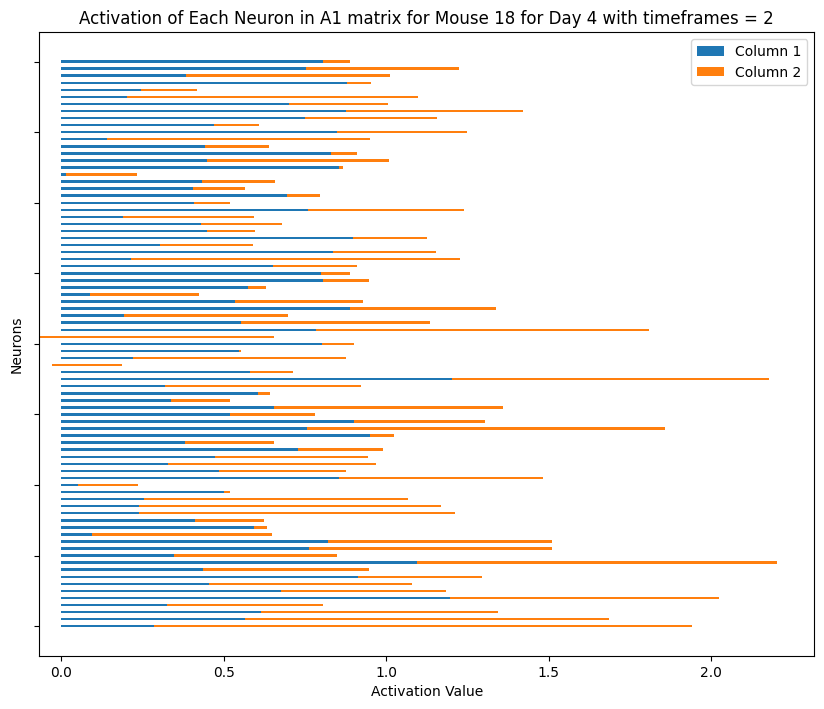

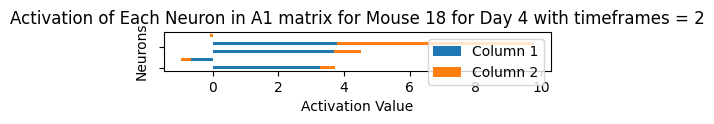

In [6]:
mouse = int(input("Which mouse data would you like to see ? (13/18)"))
timeframe = int(input("Number of time frames:"))
mat_data = scipy.io.loadmat(rf"C:\Users\ASUS\Downloads\For_Tezuka\For_Tezuka\Opto_Data_CLa{mouse}.mat")
for day in range(4):
    layers = [5,2]
    history,Afinal,S1,C,ax,fig = NNMF(mat_data,layers,day,mouse,timeframe)
    